# <span style="font-family:cursive;text-align:center">DMSP Precipitate Flux Prediction </span>

# <span style="font-family:cursive;text-align:center">⬇️ Importing Libraries</span>

In [178]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import os
from os.path import isfile, join
from sys import getsizeof
import glob

from random import *

import time

from pickle import dump
import joblib

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split

from tensorflow.keras.metrics import mean_squared_error
import keras as k
import kerastuner as kt
from keras import utils, models, layers, optimizers
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from keras.layers import Dense, GRU, BatchNormalization, Activation, LSTM, Flatten
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.models import load_model
from keras.layers import Dropout
import tensorflow as tf
from tensorflow.keras.optimizers import Adam, SGD
from keras.models import Sequential

# <span style="font-family:cursive;text-align:center">⬇️ Importing Data</span>

In [179]:
df = pd.read_csv('C:/Santhosh/DMSP Precipitate Flux Prediction/Dataset/DMSP_Data.csv')
df.head()

,Datetimes,SC_AACGM_LAT,SC_AACGM_LTIME,ELE_TOTAL_ENERGY_FLUX,ELE_TOTAL_ENERGY_FLUX_STD,ELE_AVG_ENERGY,ELE_AVG_ENERGY_STD,ID_SC,sin_ut,cos_ut,...,AE_5min,AL_5min,AU_5min,SymH_5min,PC_5min,vsw_5min,vx_5min,psw_5min,borovsky_5min,newell_5min
0,1987-01-12 12:57:00,51.143220,5.664024,2.057827e+08,0.411230,39.89341,0.411485,6.0,-0.246153,-0.969231,...,86.0,-61.0,25.0,3.0,0.77,356.0,-355.5,2.96,17439.640589,2489.686963
1,1987-01-12 12:58:00,54.137207,5.535848,2.509837e+08,0.478268,40.82392,0.478568,6.0,-0.250380,-0.968148,...,86.0,-61.0,25.0,3.0,0.77,356.0,-355.5,2.96,17439.640589,2489.686963
2,1987-01-12 13:01:00,62.928176,5.031172,4.469146e+08,0.603362,143.77360,0.604023,6.0,-0.263031,-0.964787,...,82.0,-58.0,24.0,3.0,0.77,354.7,-354.1,3.20,14199.368957,1847.748015
3,1987-01-12 13:02:00,65.719631,4.794780,1.934849e+10,0.103648,820.36560,0.103671,6.0,-0.267238,-0.963630,...,82.0,-58.0,24.0,3.0,0.77,354.7,-354.1,3.20,14199.368957,1847.748015
4,1987-01-12 13:03:00,68.392364,4.507448,3.913337e+11,0.114959,5291.57100,0.114959,6.0,-0.271440,-0.962455,...,82.0,-58.0,24.0,3.0,0.77,354.7,-354.1,3.20,14199.368957,1847.748015


# <span style="font-family:cursive;text-align:center">📊 Exploratory Data Analysis</span>

In [180]:
print(f'Dataset contains {df.shape[0]} rows and {df.shape[1]} columns')

Dataset contains 77367 rows and 154 columns


In [181]:
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77367 entries, 0 to 77366
Data columns (total 154 columns):
 #    Column                     Non-Null Count  Dtype  
---   ------                     --------------  -----  
 0    Datetimes                  77367 non-null  object 
 1    SC_AACGM_LAT               77367 non-null  float64
 2    SC_AACGM_LTIME             77367 non-null  float64
 3    ELE_TOTAL_ENERGY_FLUX      77367 non-null  float64
 4    ELE_TOTAL_ENERGY_FLUX_STD  77367 non-null  float64
 5    ELE_AVG_ENERGY             77367 non-null  float64
 6    ELE_AVG_ENERGY_STD         77367 non-null  float64
 7    ID_SC                      77367 non-null  float64
 8    sin_ut                     77367 non-null  float64
 9    cos_ut                     77367 non-null  float64
 10   sin_doy                    77367 non-null  float64
 11   cos_doy                    77367 non-null  float64
 12   sin_SC_AACGM_LTIME         77367 non-null  float64
 13   cos_SC_AACGM_LTIME         77

C:\Users\santh\AppData\Local\Temp\ipykernel_13612\2612161665.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  df.info(verbose=True, null_counts=True)


In [182]:
#Checking Duplicates :

print(df.duplicated().sum())

0


In [183]:
# Checking for missing values

# Function to calculate missing values and the columns :

def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [184]:
missing_values_table(df)

Your selected dataframe has 154 columns.
There are 48 columns that have missing values.


,Missing Values,% of Total Values
PC_30min,1,0.0
vsw_30min,1,0.0
AU_10min,1,0.0
SymH_10min,1,0.0
PC_10min,1,0.0
vsw_10min,1,0.0
vx_10min,1,0.0
psw_10min,1,0.0
borovsky_10min,1,0.0
newell_10min,1,0.0


In [185]:
df.isnull().sum()

Datetimes                    0
SC_AACGM_LAT                 0
SC_AACGM_LTIME               0
ELE_TOTAL_ENERGY_FLUX        0
ELE_TOTAL_ENERGY_FLUX_STD    0
                            ..
vsw_5min                     1
vx_5min                      1
psw_5min                     1
borovsky_5min                1
newell_5min                  1
Length: 154, dtype: int64

In [186]:
impute_cols = [x for x in df.isna().sum()[df.isna().sum() != 0].index.tolist()]
for feat in impute_cols:
    mode = df[feat].mode()[0]
    df[feat].fillna(mode, inplace=True)

In [187]:
df.isnull().sum()

Datetimes                    0
SC_AACGM_LAT                 0
SC_AACGM_LTIME               0
ELE_TOTAL_ENERGY_FLUX        0
ELE_TOTAL_ENERGY_FLUX_STD    0
                            ..
vsw_5min                     0
vx_5min                      0
psw_5min                     0
borovsky_5min                0
newell_5min                  0
Length: 154, dtype: int64

In [188]:
# Choose columns to drop
new_df = df.copy()

cols_to_drop = [c for c in new_df.columns if ('1min' in c) | ('3min' in c) | ('4min' in c) | ('_5min'in c) | ('15min' in c)| ('5hr' in c) | ('F107_' in c) | ('vx' in c) | ('AE' in c) | ('newell' in c) | ('borovsky' in c) | ('STD' in c) | ('AVG' in c) | ('SC_AACGM_LTIME'==c)]
new_df = new_df.drop(columns=cols_to_drop)

In [189]:
new_df.columns.to_list()

['Datetimes',
 'SC_AACGM_LAT',
 'ELE_TOTAL_ENERGY_FLUX',
 'ID_SC',
 'sin_ut',
 'cos_ut',
 'sin_doy',
 'cos_doy',
 'sin_SC_AACGM_LTIME',
 'cos_SC_AACGM_LTIME',
 'F107',
 'Bz',
 'By',
 'Bx',
 'AL',
 'AU',
 'SymH',
 'PC',
 'vsw',
 'psw',
 'Bz_6hr',
 'By_6hr',
 'Bx_6hr',
 'AL_6hr',
 'AU_6hr',
 'SymH_6hr',
 'PC_6hr',
 'vsw_6hr',
 'psw_6hr',
 'Bz_3hr',
 'By_3hr',
 'Bx_3hr',
 'AL_3hr',
 'AU_3hr',
 'SymH_3hr',
 'PC_3hr',
 'vsw_3hr',
 'psw_3hr',
 'Bz_1hr',
 'By_1hr',
 'Bx_1hr',
 'AL_1hr',
 'AU_1hr',
 'SymH_1hr',
 'PC_1hr',
 'vsw_1hr',
 'psw_1hr',
 'Bz_45min',
 'By_45min',
 'Bx_45min',
 'AL_45min',
 'AU_45min',
 'SymH_45min',
 'PC_45min',
 'vsw_45min',
 'psw_45min',
 'Bz_30min',
 'By_30min',
 'Bx_30min',
 'AL_30min',
 'AU_30min',
 'SymH_30min',
 'PC_30min',
 'vsw_30min',
 'psw_30min',
 'Bz_10min',
 'By_10min',
 'Bx_10min',
 'AL_10min',
 'AU_10min',
 'SymH_10min',
 'PC_10min',
 'vsw_10min',
 'psw_10min']

In [190]:
print('number of input features total = {}'.format(new_df.shape[1]))

number of input features total = 74


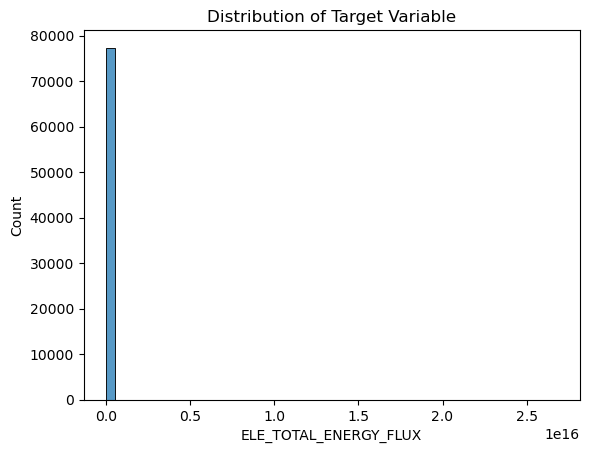

In [191]:
#Checking for the distribution of Target Variable :

sns.histplot(df['ELE_TOTAL_ENERGY_FLUX'], bins = 50)
plt.title('Distribution of Target Variable')
plt.show()

In [192]:
df['ELE_TOTAL_ENERGY_FLUX']

0        2.057827e+08
1        2.509837e+08
2        4.469146e+08
3        1.934849e+10
4        3.913337e+11
             ...     
77362    3.891807e+08
77363    1.942331e+08
77364    9.944508e+07
77365    1.767039e+08
77366    1.046599e+08
Name: ELE_TOTAL_ENERGY_FLUX, Length: 77367, dtype: float64

Converting Target variable to lograthmic form for Better Distribution

In [193]:
df['ELE_TOTAL_ENERGY_FLUX'] = np.log1p(df['ELE_TOTAL_ENERGY_FLUX'])
df['ELE_TOTAL_ENERGY_FLUX']

0        19.142331
1        19.340899
2        19.917878
3        23.685880
4        26.692826
           ...    
77362    19.779554
77363    19.084570
77364    18.415116
77365    18.989986
77366    18.466227
Name: ELE_TOTAL_ENERGY_FLUX, Length: 77367, dtype: float64

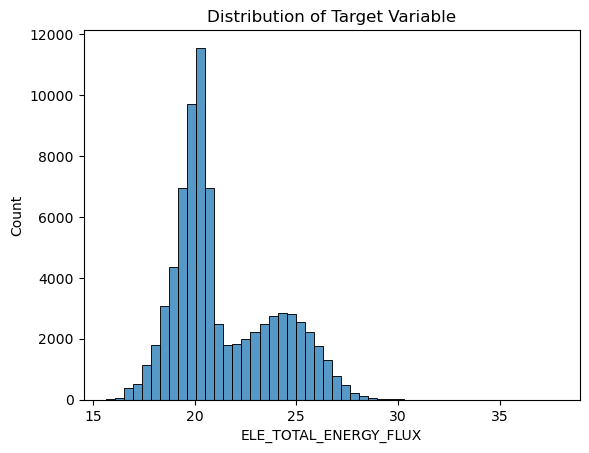

In [194]:
sns.histplot(df['ELE_TOTAL_ENERGY_FLUX'], bins = 50)
plt.title('Distribution of Target Variable')
plt.show()

In [195]:
df

,Datetimes,SC_AACGM_LAT,SC_AACGM_LTIME,ELE_TOTAL_ENERGY_FLUX,ELE_TOTAL_ENERGY_FLUX_STD,ELE_AVG_ENERGY,ELE_AVG_ENERGY_STD,ID_SC,sin_ut,cos_ut,...,AE_5min,AL_5min,AU_5min,SymH_5min,PC_5min,vsw_5min,vx_5min,psw_5min,borovsky_5min,newell_5min
0,1987-01-12 12:57:00,51.143220,5.664024,19.142331,0.411230,39.89341,0.411485,6.0,-0.246153,-0.969231,...,86.0,-61.0,25.0,3.0,0.77,356.0,-355.5,2.96,17439.640589,2489.686963
1,1987-01-12 12:58:00,54.137207,5.535848,19.340899,0.478268,40.82392,0.478568,6.0,-0.250380,-0.968148,...,86.0,-61.0,25.0,3.0,0.77,356.0,-355.5,2.96,17439.640589,2489.686963
2,1987-01-12 13:01:00,62.928176,5.031172,19.917878,0.603362,143.77360,0.604023,6.0,-0.263031,-0.964787,...,82.0,-58.0,24.0,3.0,0.77,354.7,-354.1,3.20,14199.368957,1847.748015
3,1987-01-12 13:02:00,65.719631,4.794780,23.685880,0.103648,820.36560,0.103671,6.0,-0.267238,-0.963630,...,82.0,-58.0,24.0,3.0,0.77,354.7,-354.1,3.20,14199.368957,1847.748015
4,1987-01-12 13:03:00,68.392364,4.507448,26.692826,0.114959,5291.57100,0.114959,6.0,-0.271440,-0.962455,...,82.0,-58.0,24.0,3.0,0.77,354.7,-354.1,3.20,14199.368957,1847.748015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77362,2001-08-14 00:07:00,57.812931,21.240201,19.779554,0.248978,41.87141,0.380675,14.0,0.030539,0.999534,...,59.0,-17.0,43.0,1.0,-0.59,444.7,-443.8,2.78,9239.808661,1838.558494
77363,2001-08-14 00:08:00,55.052864,21.138485,19.084570,0.318602,37.83175,0.473438,14.0,0.034899,0.999391,...,59.0,-17.0,43.0,1.0,-0.59,444.7,-443.8,2.78,9239.808661,1838.558494
77364,2001-08-14 00:10:00,49.510741,20.968127,18.415116,0.441666,32.72413,0.635324,14.0,0.043619,0.999048,...,70.0,-20.0,50.0,3.0,-0.38,424.6,-423.8,2.11,21965.214456,6469.936395
77365,2001-08-14 00:11:00,46.750041,20.896789,18.989986,0.516674,118.97360,0.726030,14.0,0.047978,0.998848,...,70.0,-20.0,50.0,3.0,-0.38,424.6,-423.8,2.11,21965.214456,6469.936395


In [196]:
# changing the date column into datetime format
df = df.set_index('Datetimes')
df.index = pd.to_datetime(df.index)

In [197]:
df.head(2)

,SC_AACGM_LAT,SC_AACGM_LTIME,ELE_TOTAL_ENERGY_FLUX,ELE_TOTAL_ENERGY_FLUX_STD,ELE_AVG_ENERGY,ELE_AVG_ENERGY_STD,ID_SC,sin_ut,cos_ut,sin_doy,...,AE_5min,AL_5min,AU_5min,SymH_5min,PC_5min,vsw_5min,vx_5min,psw_5min,borovsky_5min,newell_5min
Datetimes,,,,,,,,,,,,,,,,,,,,,
1987-01-12 12:57:00,51.143220,5.664024,19.142331,0.411230,39.89341,0.411485,6.0,-0.246153,-0.969231,0.205104,...,86.0,-61.0,25.0,3.0,0.77,356.0,-355.5,2.96,17439.640589,2489.686963
1987-01-12 12:58:00,54.137207,5.535848,19.340899,0.478268,40.82392,0.478568,6.0,-0.250380,-0.968148,0.205104,...,86.0,-61.0,25.0,3.0,0.77,356.0,-355.5,2.96,17439.640589,2489.686963


# <span style="font-family:cursive;text-align:center">🧰 Modelling :</span>

In [212]:
#train and test split & standardizing the data
def train_test_func(df):
    # train and test split
    X = df.drop('ELE_TOTAL_ENERGY_FLUX', axis=1)
    y = df['ELE_TOTAL_ENERGY_FLUX']
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=42)
    
    # scale the dataset
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    X_train = pd.DataFrame(X_train, columns=X.columns)
    X_test = pd.DataFrame(X_test, columns=X.columns)
    
    return X_train, X_test, y_train, y_test

In [213]:
X_train, X_test, y_train, y_test = train_test_func(df)
X_train.head(2)

,SC_AACGM_LAT,SC_AACGM_LTIME,ELE_TOTAL_ENERGY_FLUX_STD,ELE_AVG_ENERGY,ELE_AVG_ENERGY_STD,ID_SC,sin_ut,cos_ut,sin_doy,cos_doy,...,AE_5min,AL_5min,AU_5min,SymH_5min,PC_5min,vsw_5min,vx_5min,psw_5min,borovsky_5min,newell_5min
0,1.092719,-0.740091,-0.661062,-0.267140,-0.657544,-0.672843,-0.651450,-1.248423,-0.663863,-0.616581,...,0.128062,0.073964,0.421226,-0.072982,-0.132427,0.815794,-0.833918,-0.479704,-0.007536,-0.387590
1,-1.632118,1.272925,-0.423045,-0.341701,-0.381452,1.153158,-0.960868,-1.033459,0.306404,-1.098154,...,0.072827,-0.067150,0.066014,-0.605501,0.240244,2.958217,-2.959377,-0.529334,1.809702,1.729147


In [214]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((58025, 152), (19342, 152), (58025,), (19342,))

## Model With Keras Tuner & Callbacks :

# Model 1 : (Neural Network) 

In [215]:
# creating the function for calculation of R2-score
from keras import backend as K


def r2_score(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [216]:
def model_builder(hp):
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=[129]))

    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    model.add(keras.layers.Dense(units=hp_units, activation=keras.layers.LeakyReLU(alpha=0.01)))
    model.add(keras.layers.Dense(units=hp_units, activation=keras.layers.LeakyReLU(alpha=0.01)))
    model.add(keras.layers.Dense(1, activation='linear'))

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    metrics = [
    keras.metrics.RootMeanSquaredError(name="root_mean_squared_error"),r2_score]

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.BinaryCrossentropy(),
                metrics=metrics)

    return model

In [217]:
tuner = kt.RandomSearch(model_builder,objective='val_loss',max_trials=5)

INFO:tensorflow:Reloading Tuner from .\untitled_project\tuner0.json


In [218]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_precision', patience=5)

In [219]:
tuner.search(X_train, y_train, epochs=30, validation_data = (X_test, y_test), callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 384 and the optimal learning rate for the optimizer
is 0.0001.



In [228]:
model1 = Sequential()
model1.add(Dense(384, input_shape=(X_train.shape[1:]), kernel_initializer='uniform', activation = keras.layers.LeakyReLU(alpha=0.01)))

model1.add(Dense(192, kernel_initializer='uniform', activation=keras.layers.LeakyReLU(alpha=0.01)))

model1.add(Dense(64, kernel_initializer='uniform', activation=keras.layers.LeakyReLU(alpha=0.01)))

model1.add(Dense(1, kernel_initializer='uniform',activation='linear'))

# Compile the model

model1.compile(loss='mean_squared_error', optimizer=Adam(0.0001), metrics=[tf.keras.metrics.RootMeanSquaredError(name="root_mean_squared_error", dtype=None),r2_score])

In [229]:
model1.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_61 (Dense)            (None, 384)               58752     
                                                                 
 dense_62 (Dense)            (None, 192)               73920     
                                                                 
 dense_63 (Dense)            (None, 64)                12352     
                                                                 
 dense_64 (Dense)            (None, 1)                 65        
                                                                 
Total params: 145,089
Trainable params: 145,089
Non-trainable params: 0
_________________________________________________________________


In [231]:
history = model1.fit(X_train,y_train, validation_data=(X_test, y_test), epochs=25, batch_size=64, verbose=1, shuffle=False, callbacks=callbacks_list)

Epoch 1/25
881/907 [============================>.] - ETA: 0s - loss: 0.8069 - root_mean_squared_error: 0.8983 - r2_score: 0.8664
Epoch 1: val_loss did not improve from 0.65648
907/907 [==============================] - 1s 2ms/step - loss: 0.8060 - root_mean_squared_error: 0.8978 - r2_score: 0.8664 - val_loss: 0.8402 - val_root_mean_squared_error: 0.9166 - val_r2_score: 0.8639
Epoch 2/25
869/907 [===========================>..] - ETA: 0s - loss: 0.7520 - root_mean_squared_error: 0.8672 - r2_score: 0.8756
Epoch 2: val_loss did not improve from 0.65648
907/907 [==============================] - 1s 2ms/step - loss: 0.7521 - root_mean_squared_error: 0.8672 - r2_score: 0.8755 - val_loss: 0.7920 - val_root_mean_squared_error: 0.8899 - val_r2_score: 0.8719
Epoch 3/25
878/907 [============================>.] - ETA: 0s - loss: 0.7056 - root_mean_squared_error: 0.8400 - r2_score: 0.8834
Epoch 3: val_loss did not improve from 0.65648
907/907 [==============================] - 1s 2ms/step - loss: 

Epoch 21/25
887/907 [============================>.] - ETA: 0s - loss: 0.4001 - root_mean_squared_error: 0.6325 - r2_score: 0.9344
Epoch 21: val_loss did not improve from 0.51313
907/907 [==============================] - 1s 2ms/step - loss: 0.4011 - root_mean_squared_error: 0.6333 - r2_score: 0.9342 - val_loss: 0.5683 - val_root_mean_squared_error: 0.7538 - val_r2_score: 0.9089
Epoch 22/25
906/907 [============================>.] - ETA: 0s - loss: 0.3917 - root_mean_squared_error: 0.6258 - r2_score: 0.9356
Epoch 22: val_loss did not improve from 0.51313
907/907 [==============================] - 1s 2ms/step - loss: 0.3916 - root_mean_squared_error: 0.6257 - r2_score: 0.9357 - val_loss: 0.5275 - val_root_mean_squared_error: 0.7263 - val_r2_score: 0.9157
Epoch 23/25
885/907 [============================>.] - ETA: 0s - loss: 0.3867 - root_mean_squared_error: 0.6219 - r2_score: 0.9365
Epoch 23: val_loss did not improve from 0.51313
907/907 [==============================] - 1s 2ms/step - 

In [248]:
#Saving the Model:

model.save('dmsp_model.h5')

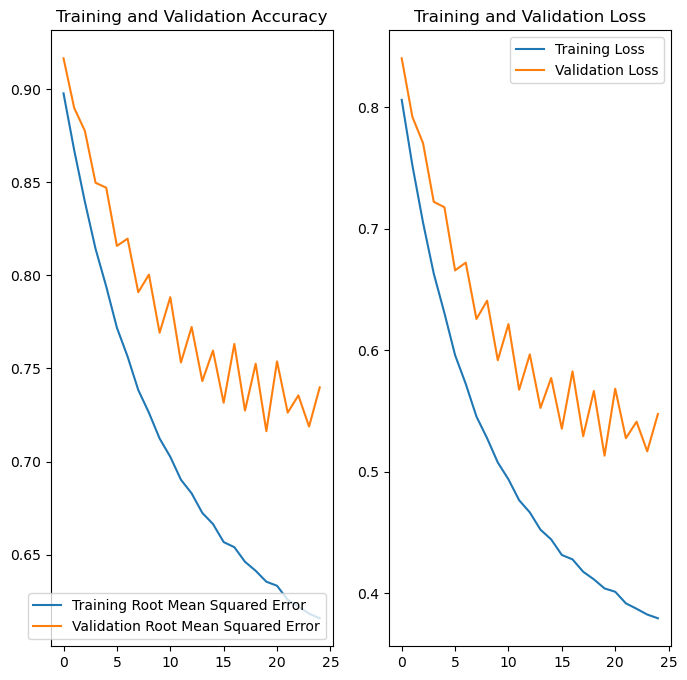

In [234]:
# code for plotting the results from the model for loss and root mean square error
rmse = history.history['root_mean_squared_error']
val_rmse = history.history['val_root_mean_squared_error']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(25)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, rmse, label='Training Root Mean Squared Error')
plt.plot(epochs_range, val_rmse, label='Validation Root Mean Squared Error')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Insights:**

- Model with Neural network has an r2 score of 0.93
- RMSE score is volatile
- RMSE score can be improved
